# Minimum Variance Portfolio, sample cov using MLE linear shrinkage

Shrinkage algorithm implemented from 
    Ledoit, O., and M. Wolf, 2003, “Honey, I Shrunk the Sample Covariance Matrix,” Working
    Paper, Department of Economics and Business, Universitat Pompeu Fabra.
Access: https://ssrn.com/abstract=433840

The performance of the shrinkage estimator is measured in MSE terms of the covariance matrix estimate, using the matrix Frobenius norm

$ ||\hat{\Sigma}-\Sigma||_F = \sqrt{\sum_{i,j} (\hat{\sigma}^2_{ij} - \sigma^2_{ij})^2 }$.
 That is, the squared residual of the element-wise covariances.
 
While the shrinkage estimator is a biased estimator, it can archive a lower MSE than the unbiased sample covariance by having a lower variance.

## Define benchmark returns statistics

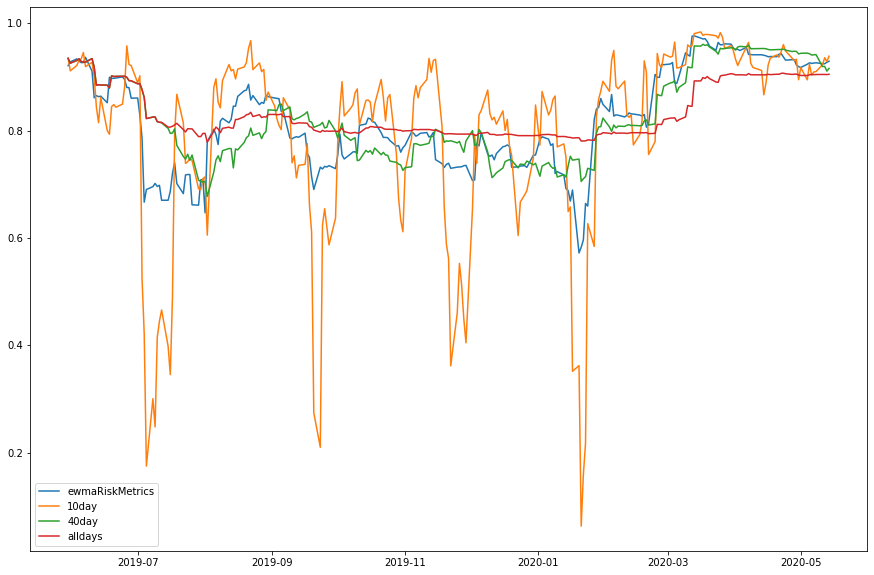

In [6]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import scipy.stats as stats
import pandas as pd
pd.plotting.register_matplotlib_converters()
from operator import add
from matplotlib import pyplot as plt
import honey_shrink as hs
import marchenko_pastur as mp
from sklearn.covariance import LedoitWolf
from src.estimation.cov_cleaning import mp_denoise, RIE
import example_data as data
import statsmodels.api as sm


def mvh(idx_r, idx_h, pos, cov):
    idx_sub = np.concatenate([idx_r, idx_h])
    hrhh = cov[idx_h][:,idx_sub]
    hh = cov[idx_h][:, idx_h]
    hdg_h = -np.linalg.inv(hh) @ hrhh @ pos[idx_sub]
    hdg = np.concatenate((np.zeros(len(idx_r)), hdg_h))
    psi = np.zeros(cov.shape[0])
    psi[idx_sub] = hdg
    return psi

#def var(book, cov):
#    return book.pos @ cov.loc[book.pos.index, book.pos.index] @ book.pos

def var(w, cov):
    return w @ cov @ w
    
# =========================
# ======= Load Data =======
# =========================
lvl_df, book = data.get_example_data()
#book._pos = book.pos[['NDA SS']]
lvl_df.index = pd.to_datetime(lvl_df.index)
#r = lvl_df.pct_change()#.iloc[1::]
r = np.log(lvl_df.shift(1)) - np.log(lvl_df)
R = lvl_df.pct_change()
rcov = r.cov() #ddof=N-1
Rcov = R.cov()
# === Get subset ===
hedges = ['SX5E']
#hedges = ['SWEDA SS']
#hedges = ['SWEDA SS', 'AMEAS FH', 'CAST SS']
subverse = set(book.pos.index.values).union(set(hedges))

rsub = r[subverse].copy()
Rsub = R[subverse].copy()
lvlsub = lvl_df[subverse]
rcovsub = rcov.loc[subverse, subverse]
Rcovsub = Rcov.loc[subverse, subverse]
#idx_r = np.array([subcov.index.get_loc(x) for x in book.pos.index])
#idx_h = np.array([subcov.index.get_loc(x) for x in hedges])

#biret = rsub#rsub[['NDA SS', 'SX5E']]
#bilvl = lvlsub#lvlsub[['NDA SS', 'SX5E']]

#plt.plot(bilvl / bilvl.iloc[0,:])
#plt.title('Asset level')

rsub['P'] = (rsub[book.pos.index] * book.pos).sum(axis=1)
Rsub['P'] = (Rsub[book.pos.index] * book.pos).sum(axis=1)
rsub = rsub.dropna()
Rsub = Rsub.dropna()

burn_in = 10
corr_online = np.zeros((rsub.shape[0], 3))
for t in range(burn_in, rsub.shape[0]):
    corr_online[t,0] = np.corrcoef(rsub[['P', 'SX5E']].iloc[t-10:t], rowvar=False)[0,1]
    corr_online[t,1] = np.corrcoef(rsub[['P', 'SX5E']].iloc[t-min(t,40):t], rowvar=False)[0,1]
    corr_online[t,2] = np.corrcoef(rsub[['P', 'SX5E']].iloc[0:t], rowvar=False)[0,1]
corr_online = pd.DataFrame(corr_online, index=rsub.index, columns=['10day', '40day', 'alldays'])

dec = 0.94
ewm = rsub[['P', 'SX5E']].ewm(alpha=1-dec, adjust=True).corr().xs('P', axis=1).xs('SX5E', axis=0, level=1)

plt.figure(figsize=(15,10))
plt.plot(ewm.iloc[burn_in::], label='ewmaRiskMetrics')
plt.plot(corr_online.index[burn_in::], corr_online['10day'][burn_in::], label='10day')
plt.plot(corr_online.index[burn_in::], corr_online['40day'][burn_in::], label='40day')
plt.plot(corr_online.index[burn_in::], corr_online['alldays'][burn_in::], label='alldays')
plt.legend()
plt.show()


# Hedge Ratio

==========ROLLING Window HR =========
10day volresid 55.68%
40day volresid 56.61%
alldays volresid 57.39%
==========EWMA Window HR =========
ewma volresid 57.39%
========== Kalman HR =========
Kalman volresid 57.74%


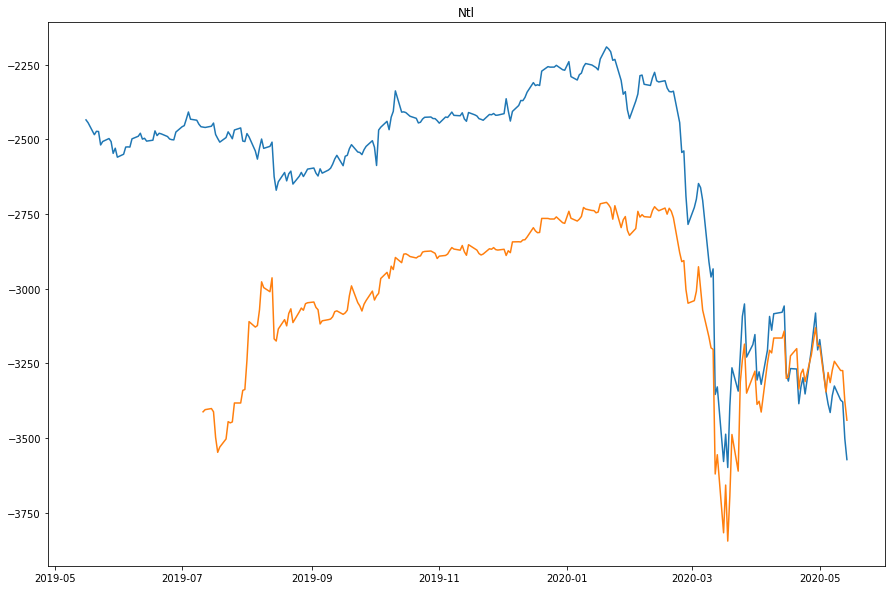

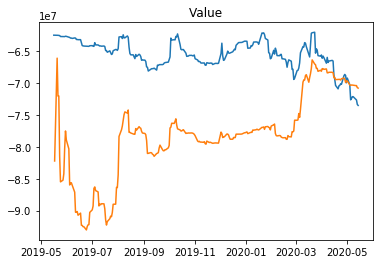

In [7]:
class Mdl:
    def __init__(self):
        self.fitted_beta = None
        self.pred_resid = None
        self.var_uhdg = None
        self.var_hdg = None
        self.hdg_ntl = None
    def vareff(self):
        return 1 - self.var_hdg / self.var_uhdg
    def voleff(self):
        return 1 - (self.var_hdg / self.var_uhdg)**0.5

print("==========ROLLING Window HR =========")
def rollingHR(window, min_periods, burn_in=0):
    cov_t = rsub[['P', 'SX5E']].rolling(window, min_periods=min_periods).cov(ddof=1)
    xcov = cov_t.xs('SX5E', axis=0, level=1).xs('P', axis=1)
    xvar = cov_t.xs('SX5E', axis=0, level=1).xs('SX5E', axis=1)
    beta_t = - xcov / xvar
    pred_resid = Rsub['P'] + beta_t.shift(1) * Rsub['SX5E'] # use last beta for pred hr next step, eval there.
    eval_start = rsub.index[burn_in]
    uhdg_var = np.var(Rsub['P'].loc[eval_start::], ddof=1)
    hdg_var = np.var(pred_resid.loc[eval_start::], ddof=1)
    ntl = beta_t.loc[eval_start::] /  lvlsub['SX5E'].loc[eval_start::]
    mdl = Mdl()
    mdl.fitted_beta = beta_t
    mdl.pred_resid = pred_resid
    mdl.var_uhdg = uhdg_var
    mdl.var_hdg = hdg_var
    mdl.hdg_ntl = ntl
    return mdl

burn_in = 40
mdl_10 = rollingHR(window=10, min_periods=1, burn_in=burn_in)
print('10day volresid {:.2f}%'.format(100*mdl_10.voleff()))
mdl_40 = rollingHR(window=40, min_periods=1, burn_in=burn_in)
print('40day volresid {:.2f}%'.format(100*mdl_40.voleff()))
mdl_alldays = rollingHR(window=9999, min_periods=1, burn_in=burn_in)
print('alldays volresid {:.2f}%'.format(100*mdl_alldays.voleff()))
print("==========EWMA Window HR =========")
def ewmaHR(decay, burn_in):
    ewm_cov = rsub[['P', 'SX5E']].ewm(alpha=1-decay, adjust=True).cov() #alpha = 1-decay in pandas implem. Adjust = normalize weights for non infinite series.
    xcov = ewm_cov.xs('P', axis=1).xs('SX5E', axis=0, level=1)
    xvar = ewm_cov.xs('SX5E', axis=1).xs('SX5E', axis=0, level=1)
    beta_t = -xcov / xvar
    pred_resid = Rsub['P'] + beta_t.shift(1) * Rsub['SX5E']
    eval_start = rsub.index[burn_in]
    uhdg_var = np.var(Rsub['P'].loc[eval_start::], ddof=1)
    hdg_var = np.var(pred_resid.loc[eval_start::], ddof=1)
    ntl = beta_t.loc[eval_start::] /  lvlsub['SX5E'].loc[eval_start::]
    mdl = Mdl()
    mdl.fitted_beta = beta_t
    mdl.pred_resid = pred_resid
    mdl.var_uhdg = uhdg_var
    mdl.var_hdg = hdg_var
    mdl.hdg_ntl = ntl    
    return mdl

decay = 0.95
mdl_ewma = ewmaHR(decay, burn_in=burn_in)
print('ewma volresid {:.2f}%'.format(100*mdl_alldays.voleff()))


print("========== Kalman HR =========")
import pykalman as pk

# ===== Generate Process =====
y = rsub['P']
x = rsub['SX5E']
#x = lvlsub['SX5E'].diff(1).iloc[1::]

# Observation matrix, mapping y(t-1) -> y(t): y(t)
observation_matrices = np.vstack([np.ones(x.shape), -x]).T[:, np.newaxis]

# ===== Transition input =====
# AR(1) or random walk assumption on state transition.
transition_matrices = np.eye(2)
# Noise for the AR(1) process. TODO: corr between state variables <=> corr(alpha, beta) is negative in OLS, maybe use this?
transition_covariance = np.eye(2)

observation_covariance = 0
# ===== Initial State guess =====
# Some reasonable start guess...
initial_state_mean = np.array([0, -book.pos.sum()])
# Some large covariance, sice we have no idea...
initial_state_covariance = np.ones((2, 2))
    
kf = pk.KalmanFilter(
                n_dim_obs=1,
                n_dim_state=2,
                initial_state_mean=initial_state_mean,
                initial_state_covariance=initial_state_covariance,
                transition_matrices=transition_matrices,
                observation_matrices=observation_matrices,
                observation_covariance=observation_covariance,
                transition_covariance=transition_covariance)

state_means, state_cov = kf.filter(y)
state_df = pd.DataFrame(index=rsub.index, data=state_means, columns=['alpha', 'beta'])

kalman_resid0 = Rsub['P']
kalman_resid = Rsub['P'] + state_df['beta'].shift(1) * Rsub['SX5E']
eval_start = rsub.index[burn_in]
kalamn_std_resid = 1 - np.std(kalman_resid.loc[eval_start::]) / np.std(kalman_resid0.loc[eval_start::])
#print(np.sqrt( (kalman_resid.loc[eval_start::]**2).sum() / (kalman_resid0.loc[eval_start::]**2).sum()) )
print('Kalman volresid {:.2f}%'.format(100*kalamn_std_resid) )


plt.figure(figsize=(15,10))
plt.title('Ntl')
plt.plot(state_df['beta'] / lvlsub['SX5E'])
plt.plot(mdl_alldays.hdg_ntl)
plt.figure()
plt.title('Value')
plt.plot(state_df['beta'])
plt.plot(mdl_alldays.fitted_beta)
#plt.plot(mdl_ewma.fitted_beta)

594745.9152917513
OLS_oracle volresid 56.66%
604592.7489240174
OLS_oracle_static volresid 56.20%


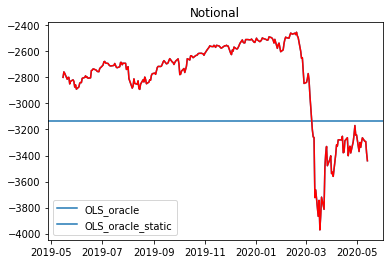

In [55]:

X = sm.add_constant(rsub['SX5E'])
Y = rsub['P']
mdl = sm.OLS(Y,-X)
rr = mdl.fit()
print(np.std(rr.resid))
h0 = Rsub['P']
h1 = Rsub['P'] + rr.params['SX5E'] * Rsub['SX5E']

hdg_eff = 1-np.std(h1)/np.std(h0)
print('OLS_oracle volresid {:.2f}%'.format(100*hdg_eff) )
plt.plot(rr.params['SX5E'] / lvlsub['SX5E'], label='OLS_oracle')
plt.title('Notional')


X = sm.add_constant(rsub['SX5E']*lvlsub['SX5E'].shift(1)[1::])
Y = rsub['P']
mdl = sm.OLS(Y,-X)
rr = mdl.fit()
print(np.std(rr.resid))
h0 = Rsub['P']
h1 = Rsub['P'] + rr.params['SX5E'] * Rsub['SX5E'] * lvlsub['SX5E']
hdg_eff = 1-np.std(h1)/np.std(h0)
print('OLS_oracle_static volresid {:.2f}%'.format(100*hdg_eff) )
plt.axhline(rr.params['SX5E'], label='OLS_oracle_static')
plt.legend(loc='best')

qq = np.cov(rsub[['P', 'SX5E']], ddof=1, rowvar=False)
rr = -qq[0,1] /  (lvlsub['SX5E'] * qq[1,1])
plt.plot(rr, color='r')

plt.show()